# Imports

In [34]:
import math
import multiprocessing
import numpy as np

from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from tqdm import tqdm

# Data Loading

In [35]:
def read_data(data_path, n_samples_to_load=None):
    """
    Reads the RCV1 dataset into lists.
    Returns the lists with samples, labels, and number of samples read.
    """
    with open(data_path, 'r') as data:
        lines = data.readlines()
        if n_samples_to_load is not None:
            lines = lines[:n_samples_to_load]
        n_samples = len(lines)
        Z, Y = [], []
        for line in lines:
            line = line.split()

            y = int(line[0])
            Y.append(y)

            z = np.zeros(N_FEATURES)
            for feature in line[1:]:
                feature_idx, feature_value = feature.split(':')
                z[int(feature_idx) - 1] = float(feature_value)
            Z.append(z)

    return Z, Y, n_samples

In [36]:
data_path = '/content/rcv1_train.binary'

N_FEATURES = 47236
n_samples_to_load = 3000 # number of samples to load (due to RAM limitation)

Z, Y, N_SAMPLES = read_data(data_path, n_samples_to_load)

In [37]:
N_DEVICES = 7
N_SAMPLES_SERVER = int(N_SAMPLES / 10)
N_ITERS = 20

In [38]:
N_SAMPLES, N_SAMPLES_SERVER, len(Z[0]) == N_FEATURES

(3000, 300, True)

# Data Distribution

Let us distribute the data (specifically, the indices of the samples) among `N_DEVICES` devices.

In [39]:
def get_proportional_label_sample(arr: np.array, label, n_samples_to_send):
    """
    Returns a proportional (uniform) sample of arr with labels equal to `label`,
    given the total size of the sample `n_samples_to_send`.
    """
    label_samples = np.where(arr == label)[0]
    n_label_samples = len(label_samples)

    n_label_samples_to_send = int(n_samples_to_send * n_label_samples / N_SAMPLES)

    np.random.shuffle(label_samples)
    label_samples_to_send = label_samples[:n_label_samples_to_send]
    return label_samples_to_send


def get_server_sample_indices(n_samples_to_send):
    """
    Returns n_samples_to_send indices that are sampled uniformly.
    Used for sampling at the server node.
    """
    Y_np = np.array(Y)
    pos_samples_to_send = get_proportional_label_sample(Y_np, 1, n_samples_to_send)
    neg_samples_to_send = get_proportional_label_sample(Y_np, -1, n_samples_to_send)

    samples_to_send = np.concatenate([pos_samples_to_send, neg_samples_to_send])
    return samples_to_send

In [40]:
def get_devices_sample_indices():
    """
    Shuffles the data and creates `N_DEVICES` equal subsets.
    """
    indices = np.arange(len(Z))
    np.random.shuffle(indices)

    return np.array_split(indices, N_DEVICES)

In [41]:
SERVER_INDICES = get_server_sample_indices(N_SAMPLES_SERVER)
DEVICES_INDICES = get_devices_sample_indices()

# SPAG Algorithm

In [42]:
def sample_loss(x, y, z, lambd):
    exp = np.exp(
        -y * (x @ z)
    )
    log = float(np.log(1 + exp))
    sample_loss = log + lambd *  np.linalg.norm(x) ** 2 / 2
    return sample_loss


def sample_grad(x, y, z, lambd):
    exp = np.exp(
        -1 * y * (x @ z)
    )
    log_der = float(exp / (1 + exp))
    return lambd * x - log_der * y * z

In [43]:
def batch_loss(x, indices, lambd):
    """
    Computes the loss function value for a batch.
    The batch contains data samples under `indices`.
    If no (None) indices provided, the total dataset loss is computed.
    """
    sum = 0

    if indices is not None:
        Z_ = np.array(Z)[indices]
        Y_ = np.array(Y)[indices]
    else:
        Z_, Y_ = Z, Y

    for z, y in zip(Z_, Y_):
        sample_loss_val = sample_loss(x, y, z, lambd)
        sum += sample_loss_val

    batch_loss = sum / len(Z_)

    return batch_loss


def batch_grad(x, indices, lambd):
    """
    Computes the gradient for a batch.
    The batch contains data samples under `indices`.
    If no (None) indices provided, the total dataset gradient is computed.
    """
    grad_f = np.zeros(N_FEATURES)

    if indices is not None:
        Z_ = np.array(Z)[indices]
        Y_ = np.array(Y)[indices]
    else:
        Z_, Y_ = Z, Y

    for z, y in zip(Z_, Y_):
        one_point_grad_loss = sample_grad(x, y, z, lambd)
        grad_f += one_point_grad_loss

    batch_grad = grad_f / len(Z_)

    return batch_grad

In [44]:
def phi_grad(x, lambd):
    f = batch_loss(x, SERVER_INDICES, lambd)
    grad_f = batch_grad(x, SERVER_INDICES, lambd)

    phi = f + MU * (np.linalg.norm(x)) ** 2 / 2
    grad_phi = grad_f + MU * x

    return phi, grad_phi

In [45]:
def bregman_difference(x, phi_x, y, phi_y, grad_phi_y):
    return phi_x - phi_y - grad_phi_y @ (x - y)


def V_grad(x, grad_F, eta, beta, v, y, lambd):
    phi_x, grad_phi_x = phi_grad(x, lambd)
    phi_y, grad_phi_y = phi_grad(y, lambd)
    phi_v, grad_phi_v = phi_grad(v, lambd)

    bregman_xv = bregman_difference(x, phi_x, v, phi_v, grad_phi_v)
    bregman_xy = bregman_difference(x, phi_x, y, phi_y, grad_phi_y)

    V = eta * grad_F @ x + (1 - beta) * bregman_xv + beta * bregman_xy

    grad_V = eta * grad_F + grad_phi_x - beta * grad_phi_y - (1 - beta) * grad_phi_v

    return V, grad_V

In [46]:
def compute_condition(x, y, v, v_new, lambd, alpha, beta, G):
    phi_x, grad_phi_x = phi_grad(x, lambd)
    phi_y, grad_phi_y = phi_grad(y, lambd)
    phi_v, grad_phi_v = phi_grad(v, lambd)
    phi_v_new, grad_phi_v_new = phi_grad(v_new, lambd)

    bregman_xy = bregman_difference(x, phi_x, y, phi_y, grad_phi_y)
    bregman_vvnew = bregman_difference(v_new, phi_v_new, v, phi_v, grad_phi_v)
    bregman_vynew = bregman_difference(v_new, phi_v_new, y, phi_y, grad_phi_y)

    return bregman_xy <= alpha ** 2 * G * ((1 - beta) * bregman_vvnew + beta * bregman_vynew)


def SPAG(init_point, L, sigma, n_iters):
    pool = multiprocessing.Pool(processes = N_DEVICES)

    x = np.empty([n_iters + 1, N_FEATURES])
    x[0] = init_point
    v = x[0]
    A, B, G = 0, 1, 1

    for t in range(n_iters):
        G = max(1, G / 2) / 2
        condition = False
        n_repetitions = 0

        while not condition:
            G = 2 * G

            a_quad_eq = sigma - L * G
            b_quad_eq = sigma * A + B
            c_quad_eq = A * B
            a = max(np.roots([a_quad_eq, b_quad_eq, c_quad_eq]))

            A = A + a
            B = B + a * sigma

            """
            alpha, beta, eta are scalars used in the
            later updates for the three vectors y[t], v[t+1] and x[t+1]
            """
            alpha   = a / A
            beta    = a / B * sigma
            eta     = a / B

            y = (1 / (1 - alpha * beta)) * ((1 - alpha) * x[t] + alpha * (1 - beta) * v)

            # compute grad_F(y) - requires communication
            args = [(y, DEVICES_INDICES[n], LAMBDA) for n in range(N_DEVICES)]
            grads = pool.starmap_async(batch_grad, args).get()
            grad_Fy = sum(grads) / N_DEVICES

            # minimize V_t(x)
            args = [grad_Fy, eta, beta, v, y, LAMBDA]
            v_new, _, _ = fmin_l_bfgs_b(V_grad, x0=v, args=args, maxiter=20)
            x[t+1] = (1 - alpha) * x[t] + alpha * v_new

            # compute the condition for iteration finish
            condition = compute_condition(x[t+1], y, v, v_new, LAMBDA, alpha, beta, G)
            n_repetitions += 1

        print(f'Iter {t}: {n_repetitions} repetitions')
        v = v_new

    return x

# Nesterov Accelerated Gradient Method

In [61]:
def AGD(f, grad_f, step_size, init_x=np.zeros(N_FEATURES), n_iterations=100):
    x = init_x
    lambda_prev = 0
    lambda_curr = 1
    gamma = 0.9 # momentum term
    y_prev = x
    alpha = step_size

    gradient = grad_f(x, None, LAMBDA)

    xs, ys = [], []

    for i in tqdm(range(n_iterations+1)):
        y_curr = x - alpha * gradient
        x = (1 - gamma) * y_curr + gamma * y_prev
        y_prev = y_curr

        lambda_tmp = lambda_curr
        lambda_curr = (1 + math.sqrt(1 + 4 * lambda_prev * lambda_prev)) / 2
        lambda_prev = lambda_tmp

        gamma = (1 - lambda_prev) / lambda_curr

        gradient = grad_f(x, None, LAMBDA)
        xs.append(x)

        loss = f(x, None, LAMBDA)
        ys.append(loss)

    return xs, ys

# Searching for Hyperparameters

In [48]:
def batch_loss_grad(x, indices, lambd):
    return batch_loss(x, indices, lambd), batch_grad(x, indices, lambd)

LAMBDA = 1e-7

# get initial point
x0, _, _ = fmin_l_bfgs_b(
    batch_loss_grad,
    x0 = np.zeros(N_FEATURES),
    args = [SERVER_INDICES, LAMBDA],
    maxiter = 20
)

len(x0) == N_FEATURES

True

In [49]:
L_F_phi = 1

mus = [1e-3, 1e-5, 1e-7]
lambdas = [1e-3, 1e-5, 1e-7]
server_sample_fractions = [0.05, 0.1, 0.2]

In [ ]:
best_mu, best_lambda, best_fraction = None, None, None
best_loss = np.inf

for mu in mus:
    for lambd in lambdas:
        for fraction in server_sample_fractions:
            n_samples_server = N_SAMPLES * fraction
            sigma_F_phi = lambd / (lambd + 2 * mu)
            SERVER_INDICES = get_server_sample_indices(n_samples_server)
            xs = SPAG(x0, L_F_phi, sigma_F_phi, N_ITERS)

            pool = multiprocessing.Pool(processes = N_DEVICES)
            for item in tqdm(xs):
                args = [(item, DEVICES_INDICES[n], LAMBDA) for n in range(N_DEVICES)]
                losses = pool.starmap_async(batch_loss, args).get()
                loss_val = sum(losses) / N_DEVICES

            if loss_val < best_loss:
                best_loss = loss_val
                best_mu, best_lambda, best_fraction = mu, lambd, fraction

# Running the Algorithms

### SPAG

In [50]:
MU = 1e-3
LAMBDA = 1e-7
sigma_F_phi = LAMBDA / (LAMBDA + 2 * MU)

In [51]:
xs_spag = SPAG(x0, L_F_phi, sigma_F_phi, N_ITERS)

Iter 0: 1 repetitions
Iter 1: 2 repetitions
Iter 2: 1 repetitions
Iter 3: 1 repetitions
Iter 4: 1 repetitions
Iter 5: 1 repetitions
Iter 6: 1 repetitions
Iter 7: 1 repetitions
Iter 8: 1 repetitions
Iter 9: 1 repetitions
Iter 10: 1 repetitions
Iter 11: 1 repetitions
Iter 12: 1 repetitions
Iter 13: 1 repetitions
Iter 14: 1 repetitions
Iter 15: 1 repetitions
Iter 16: 1 repetitions
Iter 17: 1 repetitions
Iter 18: 1 repetitions
Iter 19: 1 repetitions


In [52]:
ys_spag = []
pool = multiprocessing.Pool(processes = N_DEVICES)
for item in tqdm(xs_spag):
    args = [(item, DEVICES_INDICES[n], LAMBDA) for n in range(N_DEVICES)]
    losses = pool.starmap_async(batch_loss, args).get()
    loss_val = sum(losses) / N_DEVICES
    ys_spag.append(loss_val)

100%|██████████| 21/21 [01:29<00:00,  4.26s/it]


### Accelerated Gradient Descent

In [62]:
xs_agd, ys_agd = AGD(batch_loss, batch_grad, init_x=x0, step_size=10, n_iterations=N_ITERS)

100%|██████████| 21/21 [00:35<00:00,  1.71s/it]


# Convergence Graphs

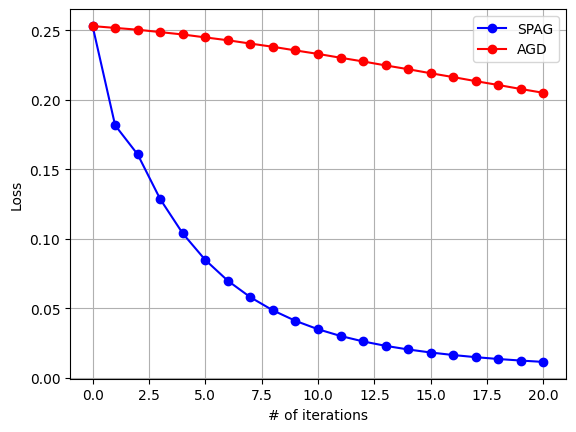

In [65]:
x = range(N_ITERS + 1)

plt.plot(x, ys_spag, '-o', color='blue', label='SPAG')
plt.plot(x, ys_agd, '-o', color='red', label='AGD')

plt.xlabel(f'# of iterations')
plt.ylabel(f'Loss')
plt.legend()
plt.grid()
plt.show()